# Case para *Data Science* Plannera

Neste *Jupyter Notebook* está a análise e tratamento dos dados cedidos como um *case* pela empresa Plannera. 

Fora as  bibliotecas padrões de *data science*, como pandas, numPy, scikit-learn e matplotlib, algumas bibliotecas extras foram utilizadas:

- seaborn, uma biblioteca para gerar gráficos. Para instalar, execute o comando 
> pip install seaborn

- scikit-lego, uma biblioteca que expande as funções da biblioteca scikit-learn. Para instalar, execute o comando
> pip install scikit-lego

Esse *notebook* importa suas funções de outros arquivos em Python. Para mais detalhes, dê uma olhada neles.

In [69]:
from geradorExcel import gerarExcel

from randomForest import gerarResultadoRandomForest, gerarResultadoZIRRandomForest
from linearRegression import gerarResultadoLinearRegression, gerarResultadoRidgeRegression
from geradorGraficos import gerarGraficoMensal, gerarGraficoLinear, gerarGraficoMensalClusterEspecifico, gerarHistograma
from tratamentoDados import gerarDados, gerarMesTeste
from poisson import gerarResultadoPoisson, gerarResultadoZIRPoisson
from geradorMetricas import gerarMetricaGeral, gerarMetricasClusters

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

Os dados históricos são lidos e tratados. Os dados sem o *target* estão em x. O *target* está em y. Os detalhes do tratamento dos dados estão em tratamentoDados.py.

In [70]:
X, y = gerarDados()

Para checar como é o formato do *target* que é buscado, é necessário analisar como é distribuido o *target* de cada elemento do conjunto de dados.

In [71]:
print(y.describe())

count    3360.000000
mean      632.178274
std      1080.704647
min         0.000000
25%         1.000000
50%       317.000000
75%       678.000000
max      7810.000000
Name: Remessas, dtype: float64


Pelo fato de ter elementos com o *target* de valor 0, isso pode prejudicar os modelos regressores que serão utilizados. 

Assimetria: 3.242776156654992
Curtose: 10.797080703001154


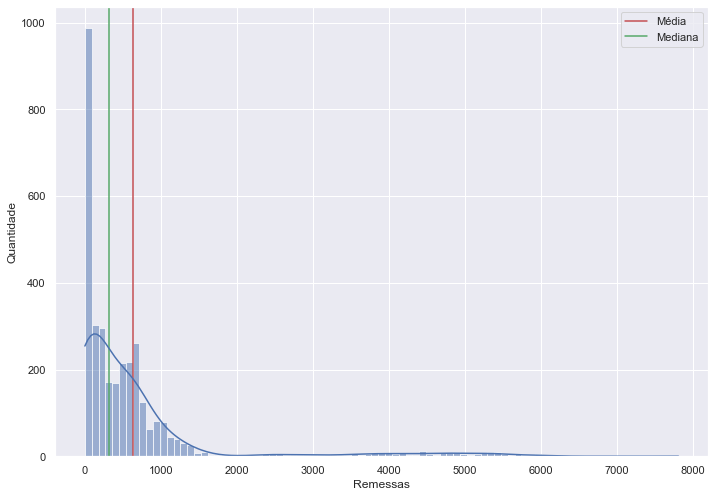

In [72]:
gerarHistograma(y)

Como o conjunto de dados não tem elementos negativos, a assimetria é positiva, indicando que existem mais elementos à direita do pico da função de distribuição. A curtose positiva indica uma curva leptocurtica, indicando que existem mais valores no *target* que fogem da média do que valores que convirjam [para a média].

### O problema: o modelo é inflado por zeros

Utilizando o histograma, é fácil de perceber que existem muitos valores 0 no *target*. Isso prejudicará os modelos na hora da predição. Quando um conjunto de dados tem uma grande quantidade de valores no *target* como 0, isso pode atrapalhar o treinamento de um modelo regressor. Esses problemas são chamados de *zero-inflated*, ou inflados por zeros.

Uma solução para esse tipo de distribuição no conjunto de dados: utilizar um modelo em duas partes, que será explicado futuramente.

### Outra maneira de ver o conjunto de dados

Outro jeito de visualizar o *target* é comparar o mesmo com outra *feature* que é diretamente proporcional ao mesmo: Volume. Cria-se, então, o gráfico "Remessas x Volume".

Text(0, 0.5, 'Remessas')

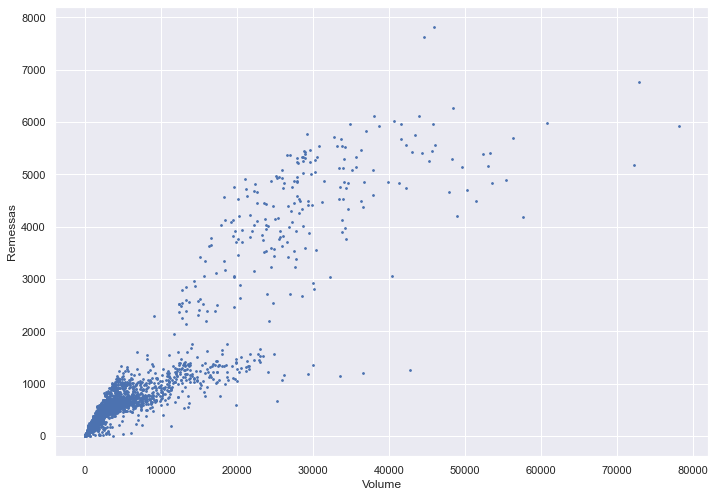

In [73]:
plt.clf()

plt.scatter(X['Volume'], y, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Realmente a relação entre essas duas *features* é mais ou menos diretamente proporcional. Com essa informação, pode-se concluir que a predição de um mês será do mesmo modelo: na maioria das vezes, quanto maior a *feature* volume, maior o *target* Remessas.

## Separando os dados em treinamento e teste

Para ter uma métrica de cada modelo e o quão preciso é o mesmo, é utilizado o próprio conjunto de dados com o *target* que temos. É, então, selecionado um mês disponível no conjunto de dados para ser separado como teste. O resto dos meses serão utilizados para treinamento de cada modelo preditivo.

In [74]:
mes = 3
ano = 2020

Para fins de teste, foi escolhido o mês de Março de 2020. Qualquer outro mês existente no conjunto de dados "Dados Históricos" pode ser escolhido. 

In [75]:
X_treino, X_teste, y_treino, y_teste = gerarMesTeste(X, y, mes, 2020)

Text(0, 0.5, 'Remessas')

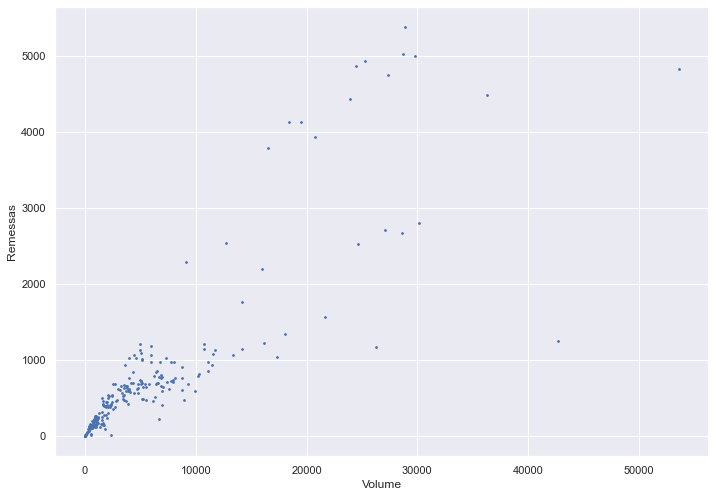

In [76]:
plt.clf()

plt.scatter(X_teste['Volume'], y_teste, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

## Os modelos

### *Random Forest* convencional

Um dos modelos escolhidos para esse *case* foi o *Random Forest*. O *Random Forest* é um modelo pretidivo do tipo *ensemble*, ou seja, é um conjunto de outros modelos preditivos, nesse caso, a árvore de decisão. Esse modelo pode ser usado tanto para problemas de classificação quanto para regressão. Esse modelo preditor consegue lidar bem com *targets* com um excesso de valores 0, então foi uma opção na hora de escolher um modelo para o *case*.

In [77]:
resultadoRF = gerarResultadoRandomForest(X_treino, X_teste, y_treino)

Após a criação do modelo *Random Forest* e seu treinamento, o resultado é calculado. Após isso, é comparado o mesmo com o valor real do mês, dado que temos esse valor no conjunto de dados.

Text(0, 0.5, 'Remessas previstas')

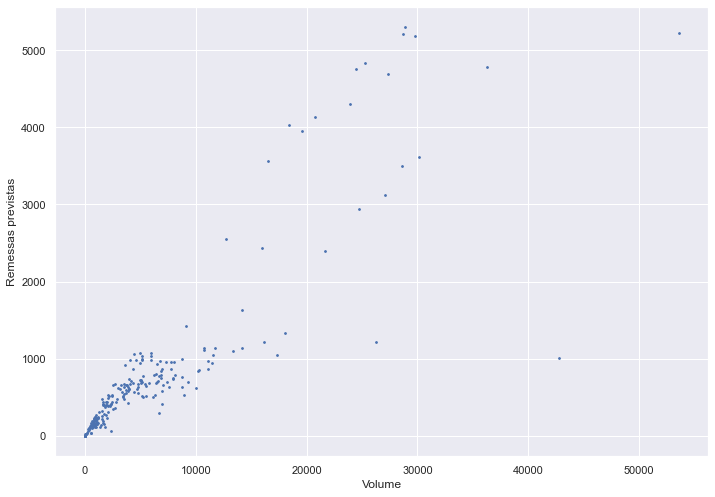

In [78]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoRF, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas previstas")

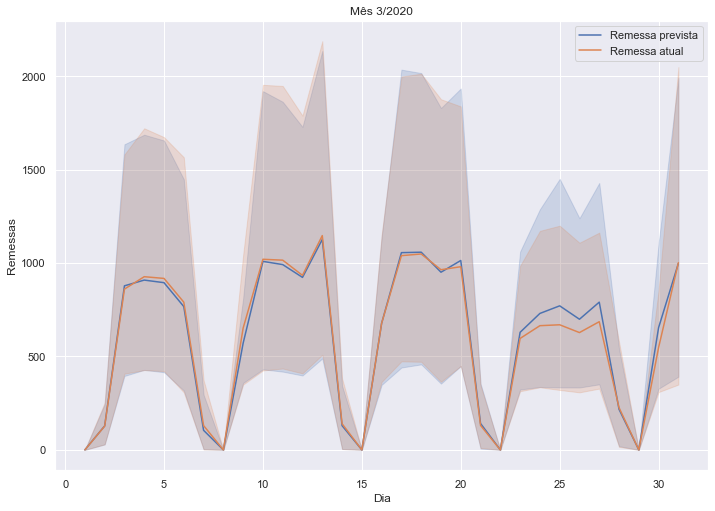

In [79]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultadoRF, comecoMes = 0, saveImage = True, nome = 'RF mensal')

As linhas representam os valores médios de cada *Cluster*. As áreas em volta das linhas são os valores reais e sua flutuação. As linhas e as áreas estão bem próximas uma das outras, indicando que o modelo criado parece estar bom. Mas, o quão bom está?

In [80]:
gerarMetricaGeral(y_teste, resultadoRF)

Mean Squared Error: 13034.868711612902
Root Mean Squared Error: 114.17034952917024
Mean Absolute Error: 33.918838709677416



Dado que cada métrica pode variar de 0 até o infinito, parece que os resultados não são os melhores, apesar do gráfico nos mostrar que o resultado está bem próximo do valor original. Que tal ver os gráficos e as medidas isoladas de cada *Cluster*? Talvez um ou mais sejam um *outlier*, ou seja, algo fora do padrão, que pode ir contra ao que o modelo aprendeu. 

<Figure size 842.4x595.44 with 0 Axes>

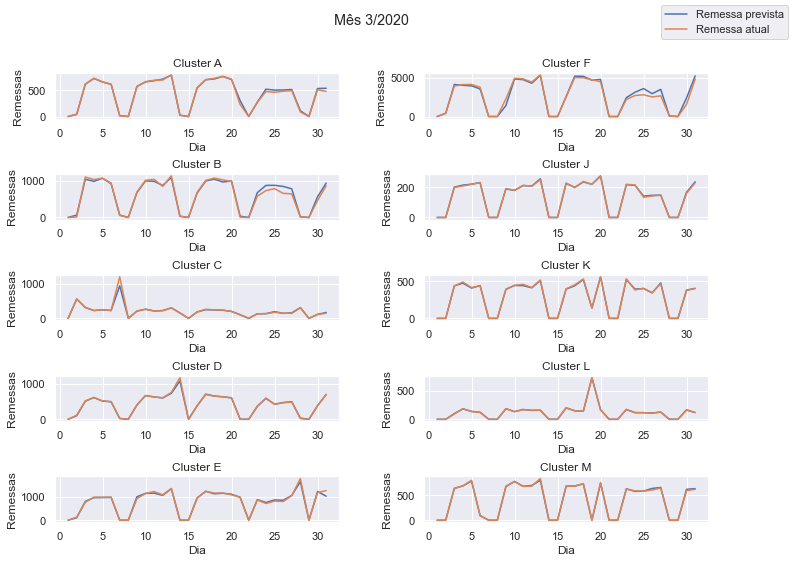

In [81]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultadoRF, comecoMes = 0, saveImage = True, nome = 'clustersRF')

Só pelo gráfico, dá para ver que o modelo é até bem preciso no maior dos casos. Os *Clusters* que tem mais diferença entre o valor real e o predito são o B e o F. 

In [82]:
gerarMetricasClusters(X_teste, y_teste, resultadoRF)

No Cluster A
Mean Squared Error: 496.10394193548393
Root Mean Squared Error: 22.273390894416682
Mean Absolute Error: 12.852258064516125

No Cluster B
Mean Squared Error: 4135.584422580645
Root Mean Squared Error: 64.30850972134749
Mean Absolute Error: 43.42677419354839

No Cluster C
Mean Squared Error: 2326.1949225806457
Root Mean Squared Error: 48.230642983280305
Mean Absolute Error: 12.961935483870967

No Cluster D
Mean Squared Error: 369.60052258064553
Root Mean Squared Error: 19.224997336297488
Mean Absolute Error: 8.132258064516131

No Cluster E
Mean Squared Error: 3189.9266387096786
Root Mean Squared Error: 56.479435538164495
Mean Absolute Error: 30.92516129032258

No Cluster F
Mean Squared Error: 119641.64227096774
Root Mean Squared Error: 345.89252994386527
Mean Absolute Error: 216.25677419354832

No Cluster J
Mean Squared Error: 10.585935483870964
Root Mean Squared Error: 3.253603461374936
Mean Absolute Error: 2.120645161290321

No Cluster K
Mean Squared Error: 41.719477419354

Utilizando as métricas, é confirmado as suspeitas: enquanto a média do erro absoluto varia entre 2 e 30 nos outros *Clusters*, o B e o F têm a média de erro absoluto de 44 e 214, respectivamente.

O resultado será salvo como um arquivo em Excel.

In [83]:
gerarExcel(resultadoRF, X_teste, mes = mes, ano = ano, nome = 'RandomForest', train = True)

### *Random Forest* como um regressor inflado com zeros (*Zero-Inflated Regressor*)

Para resolver o problema do *target* ser inflado por zeros e possivelmente melhorar os resultados do *Random Forest*, a biblioteca scikit-lego tem a implementação de um *Zero-Inflated Regressor*, ou ZIR. 

A grande diferença desse modelo para o *Random Forest* convencional é que, durante o treino, este roda um classificador para treinar qual valor no *target* é 0 e qual não é. Após isso, os valores que são diferentes de 0 são utilizados para treinar outro modelo, dessa vez, um regressor. Como o *Random Forest* funciona para ambos os problemas, o ZIR utilizado nesse conjunto de dados utilizará o *Random Forest* tanto para a parte de classificação quanto para a parte de regressão.

In [84]:
resultadoZIR = gerarResultadoZIRRandomForest(X_treino, X_teste, y_treino)

Text(0, 0.5, 'Remessas')

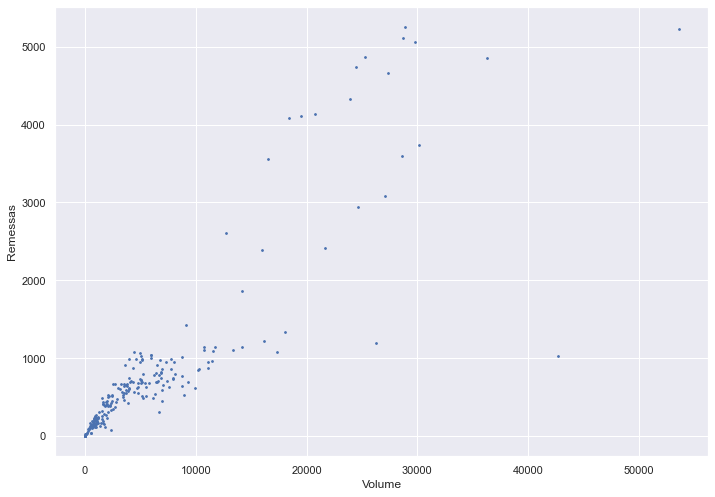

In [85]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoZIR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Então, o gráfico é gerado com o resultado.

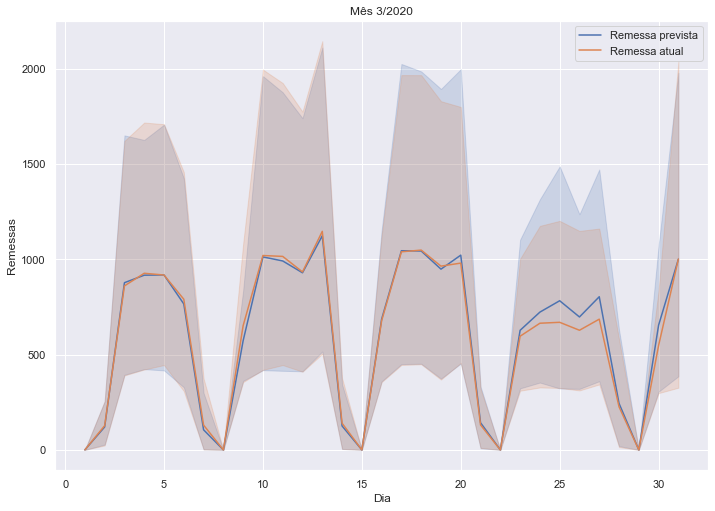

In [86]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultadoZIR, comecoMes = 0, saveImage = True, nome = 'ZIR mensal')

Como antes, será exibido as suas métricas avaliativas.

In [87]:
gerarMetricaGeral(y_teste, resultadoZIR)

Mean Squared Error: 14116.309103870972
Root Mean Squared Error: 118.81207473935876
Mean Absolute Error: 34.27858064516129



Os resultados das métricas são melhores que o *Random Forest* convencional. Após isso, tem o gráfico comparativo de cada *Cluster* e suas métricas.

<Figure size 842.4x595.44 with 0 Axes>

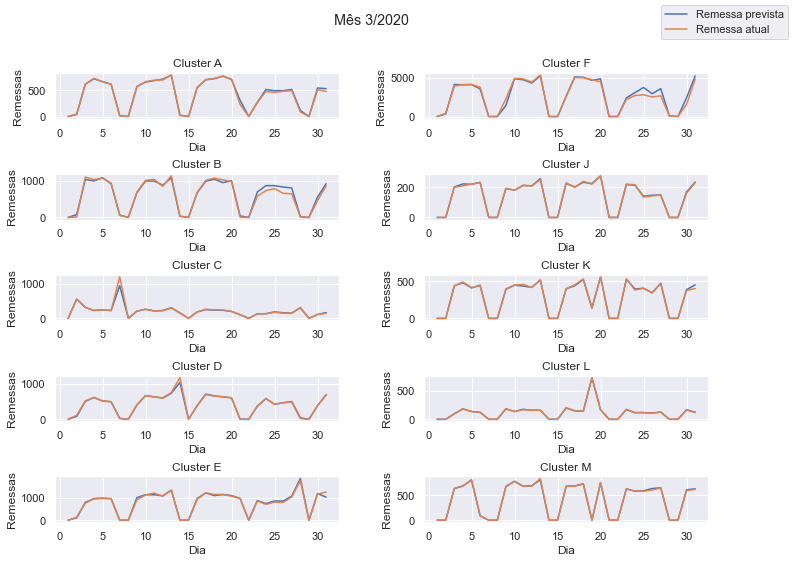

In [88]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultadoZIR, comecoMes = 0, saveImage = True, nome = 'clustersZIR')

Como antes, os *Clusters* B e F apresentam a maior diferença entre predição e valor real. Mas, os *Clusters* individuais tiveram melhora em relação ao *Random Forest* convencional?

In [89]:
gerarMetricasClusters(X_teste, y_teste, resultadoZIR)

No Cluster A
Mean Squared Error: 465.7739870967743
Root Mean Squared Error: 21.58179758724408
Mean Absolute Error: 12.641935483870968

No Cluster B
Mean Squared Error: 4258.618706451615
Root Mean Squared Error: 65.25809303413344
Mean Absolute Error: 45.185483870967744

No Cluster C
Mean Squared Error: 2246.6178064516134
Root Mean Squared Error: 47.39850004432222
Mean Absolute Error: 12.500645161290326

No Cluster D
Mean Squared Error: 720.6792387096779
Root Mean Squared Error: 26.845469612388566
Mean Absolute Error: 10.550967741935484

No Cluster E
Mean Squared Error: 2946.071258064515
Root Mean Squared Error: 54.27772340532085
Mean Absolute Error: 31.616774193548387

No Cluster F
Mean Squared Error: 130293.53105483874
Root Mean Squared Error: 360.9619523645653
Mean Absolute Error: 214.53774193548387

No Cluster J
Mean Squared Error: 14.890177419354826
Root Mean Squared Error: 3.8587792654354858
Mean Absolute Error: 2.4416129032258063

No Cluster K
Mean Squared Error: 124.8707612903226

A melhora não foi muito significativa, mas foi, mesmo assim, uma melhora.

De novo, os valores foram salvos em um arquivo Excel.

In [90]:
gerarExcel(resultadoZIR, X_teste, mes = mes, ano = ano, nome = 'ZIR_RandomForest', train = True)

### Regressão linear padrão

A Regressão Linear é um algoritmo que treina a partir de *feature*(s) do conjunto de dados e traça uma linha no gráfico que representa a correlação entre a(s) *feature*(s) e o *target*. A linha é formada a partir desta fórmula:

> y = $\theta$ * x + b

sendo:

- $\theta$ o peso da *feature*, que representa o impacto que a mesma tem quando treinando o modelo.

- b o interceptor, ou, o termo de viés, que representa a tendência do resultado da regressão de se deslocar de maneira consistente, a partir da origem, quando perto de unidades b.

In [91]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino)

Features utilizadas: ['Volume']


Após criar e treinar o modelo de regressão linear, é gerado o resultado em um gráfico. 

Text(0, 0.5, 'Remessas')

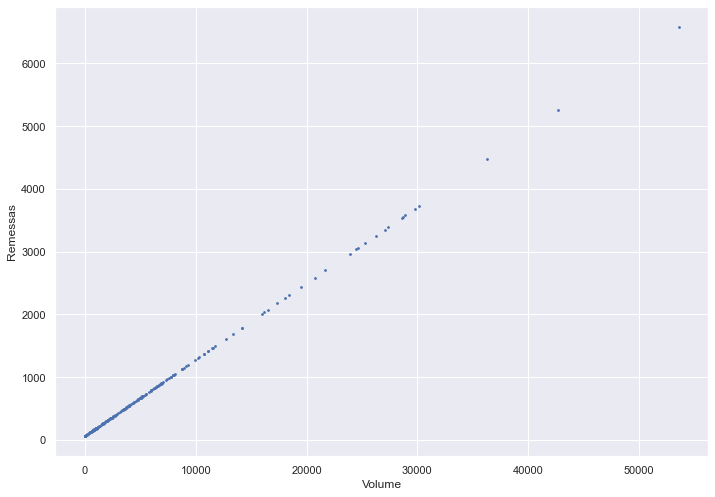

In [92]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoLR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Como esperado, o resultado da regressão linear gerou pontos muito mais ordenados que as versões de *Random Forest*.

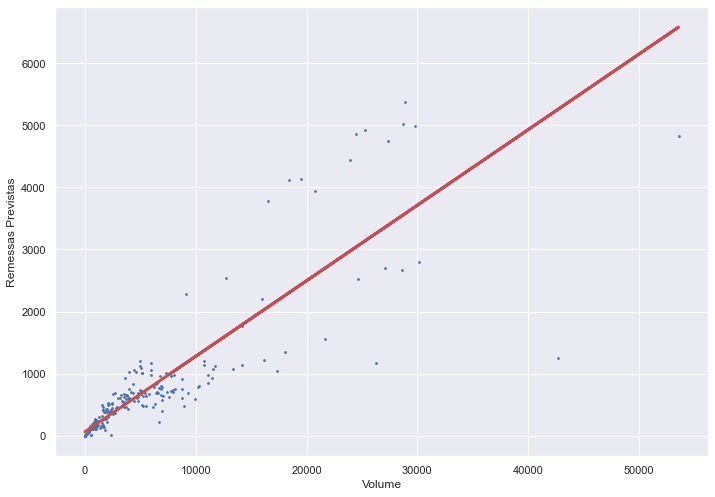

In [93]:
gerarGraficoLinear(X_teste, y_teste, resultadoLR, saveImage = True, nome = 'LR linear')

E esse é o gráfico que foi gerado, comparando o valor real do *target* com a linha gerada a partir da Regressão Linear.

Comparando esse gráfico e o resultado com os gráficos e os resultados, A regressão linear não parece ser melhor que os modelos já vistos.

O gráfico que representa a previsão do mês feita pelo modelo e as medidas avaliativas da previsão são exibidos a seguir.

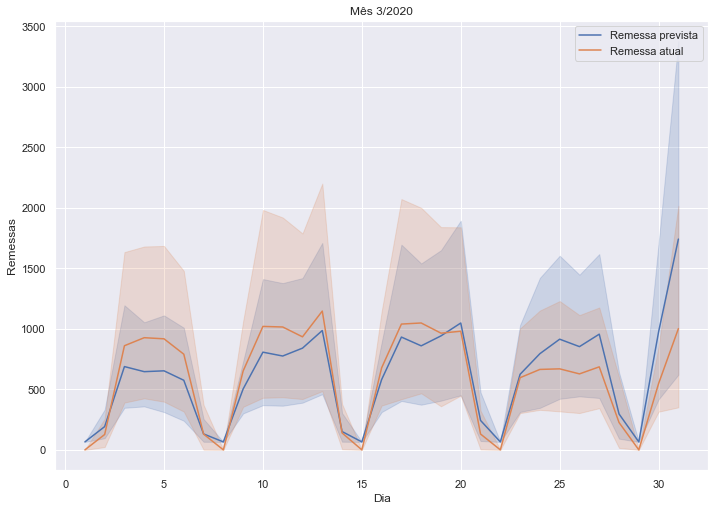

In [94]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultadoLR, comecoMes = 0, saveImage = True, nome = 'LR mensal')

In [95]:
gerarMetricaGeral(y_teste, resultadoLR)

Mean Squared Error: 227058.3625372308
Root Mean Squared Error: 476.50641395182794
Mean Absolute Error: 223.55294967485082



Uma medida extra que pode ser utilizada para avaliar o quão bom é esse modelo de Regressão Linear é a medida R^2. Essa medida revela quanto a variação do resultado pode ser explicada em relação à *feature* escolhida para treinar o modelo. Um valor perfeito é 1, podendo atingir valores negativos (pois o modelo pode ser arbitrariamente ruim em prever valores após treinado). Quando o modelo tem R^2 = 0, ele está acertando todas as predições.

In [96]:
r2LR = r2_score(y_teste, resultadoLR)

print('R^2 Score: {}'.format(r2LR))

R^2 Score: 0.7581803752241201


<Figure size 842.4x595.44 with 0 Axes>

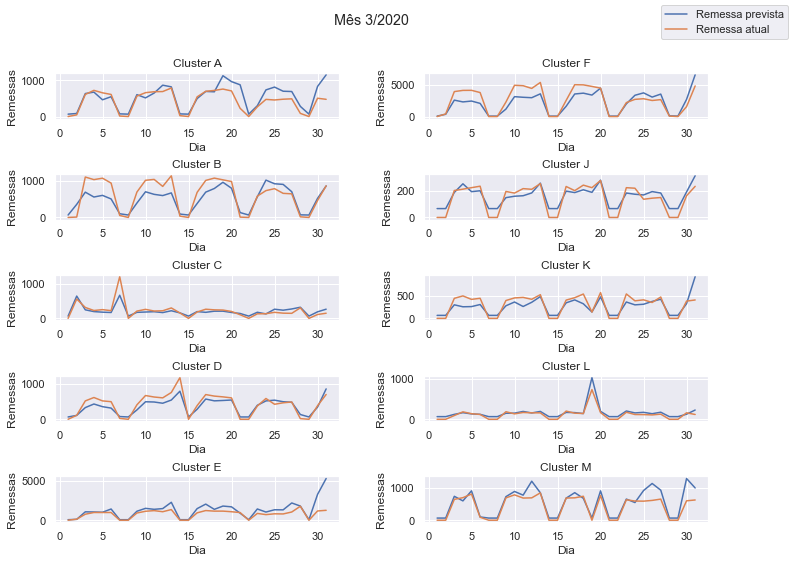

In [97]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultadoLR, comecoMes = 0, saveImage = True, nome = 'clustersRF')

In [98]:
gerarMetricasClusters(X_teste, y_teste, resultadoLR, save = True, nome = 'clusters_metricas_LR')

No Cluster A
Mean Squared Error: 53155.87166948258
Root Mean Squared Error: 230.55557175978763
Mean Absolute Error: 157.11299651781215

No Cluster B
Mean Squared Error: 66316.78595829784
Root Mean Squared Error: 257.52045735882393
Mean Absolute Error: 206.5000956412467

No Cluster C
Mean Squared Error: 13391.048282747539
Root Mean Squared Error: 115.7196970387822
Mean Absolute Error: 72.56928383822995

No Cluster D
Mean Squared Error: 18192.501619734663
Root Mean Squared Error: 134.87958192304225
Mean Absolute Error: 111.54846513909526

No Cluster E
Mean Squared Error: 839211.2198300558
Root Mean Squared Error: 916.0847230633507
Mean Absolute Error: 499.1536507980869

No Cluster F
Mean Squared Error: 1206167.7709622758
Root Mean Squared Error: 1098.2566962974893
Mean Absolute Error: 848.4738645715629

No Cluster J
Mean Squared Error: 2327.5803829210813
Root Mean Squared Error: 48.245003709411
Mean Absolute Error: 43.696515890936816

No Cluster K
Mean Squared Error: 19539.282912409166
R

Como esperado, a Regressão Linear tem uma média de erro muito maior que os modelos baseados em *Random Forest*. 

Um jeito de aprimorar a Regressão Linear é utilizar mais do que uma *feature* para treinar o modelo. 

In [99]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino, n = 8)

Features utilizadas: ['Volume', 'Dropsize', 'Dia', 'Mês', 'Ano', 'é_dia_normal', 'é_feriado', 'é_fim_de_semana']


Text(0, 0.5, 'Remessas')

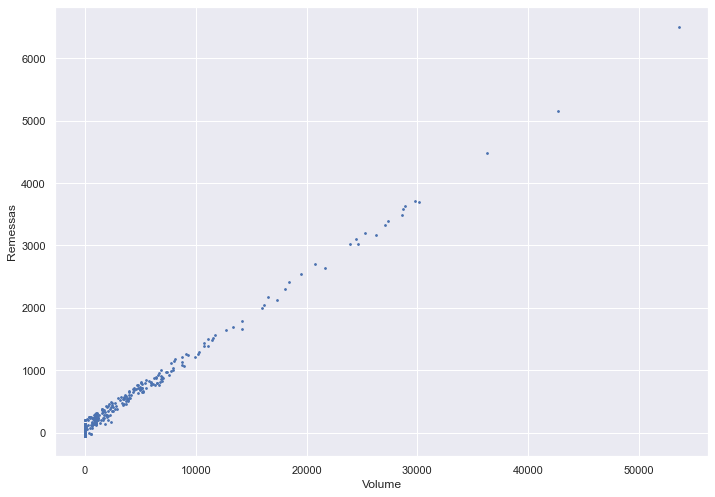

In [100]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoLR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

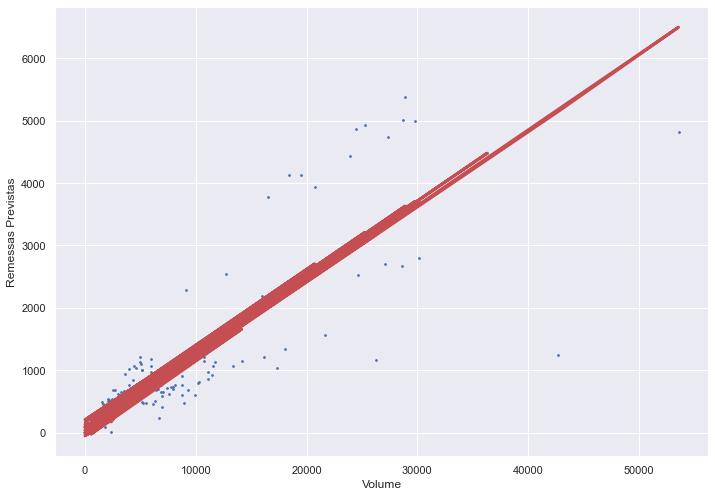

In [101]:
gerarGraficoLinear(X_teste, y_teste, resultadoLR, saveImage = True, nome = 'LR linear')

A linha que intercepta os pontos passa a ser uma função mais complexa que somente uma função de 1º grau. Porém, a complexidade torna ela mais próxima do que os valores reais são, melhorando, assim, a predição do modelo.

In [102]:
gerarMetricaGeral(y_teste, resultadoLR)

Mean Squared Error: 209445.00857526233
Root Mean Squared Error: 457.651623590764
Mean Absolute Error: 214.25583213612583



In [103]:
r2LR = r2_score(y_teste, resultadoLR)

print('R^2 Score: {}'.format(r2LR))

R^2 Score: 0.7769387886933865


Como o modelo se comportará, então, se usarmos todas as *features*?

In [104]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino, n = 18)

Features utilizadas: ['Volume', 'Dropsize', 'Dia', 'Mês', 'Ano', 'é_dia_normal', 'é_feriado', 'é_fim_de_semana', 'Cluster_A', 'Cluster_B', 'Cluster_C', 'Cluster_D', 'Cluster_E', 'Cluster_F', 'Cluster_J', 'Cluster_K', 'Cluster_L', 'Cluster_M']


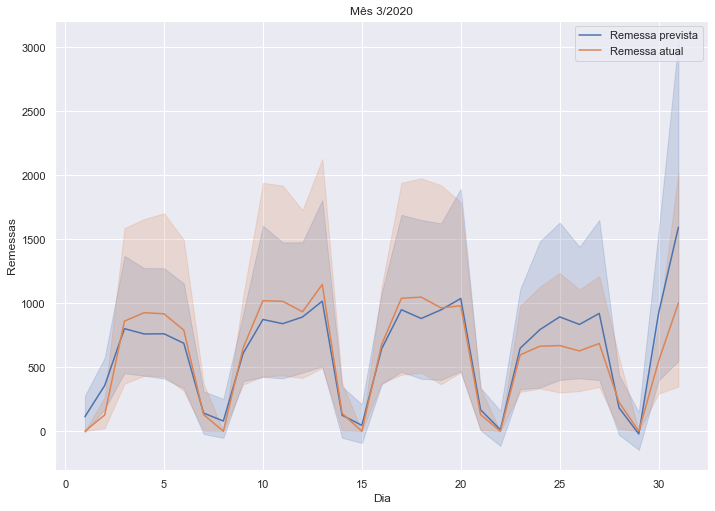

In [105]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultadoLR, comecoMes = 0, saveImage = True, nome = 'LR mensal')

<Figure size 842.4x595.44 with 0 Axes>

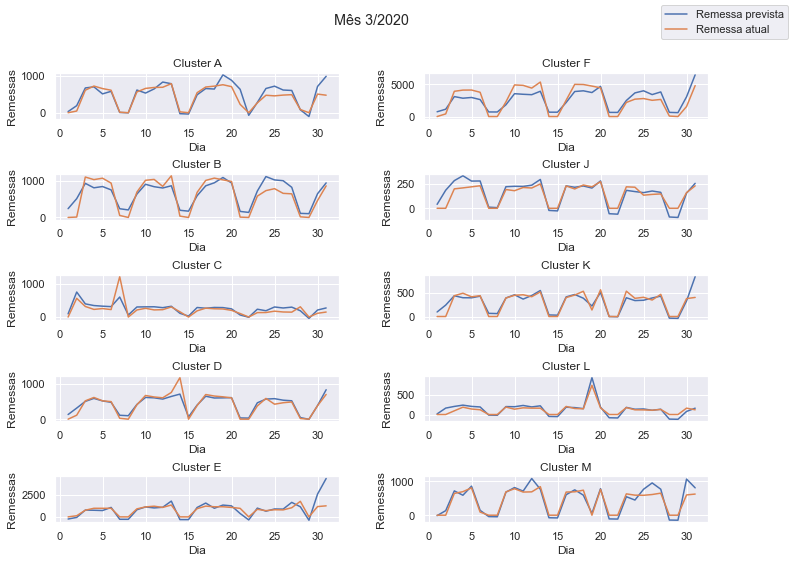

In [106]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultadoLR, comecoMes = 0, saveImage = True, nome = 'clustersRF')

Parece um pouco melhor em relação a antes, mas não muito promissor... A seguir, as métricas:

In [107]:
gerarMetricasClusters(X_teste, y_teste, resultadoLR)

No Cluster A
Mean Squared Error: 26746.61820478904
Root Mean Squared Error: 163.54393356156334
Mean Absolute Error: 113.75913069029657

No Cluster B
Mean Squared Error: 40279.193265632755
Root Mean Squared Error: 200.6967694449334
Mean Absolute Error: 174.80694238118446

No Cluster C
Mean Squared Error: 19362.95868557204
Root Mean Squared Error: 139.15084866996693
Mean Absolute Error: 93.26301932433665

No Cluster D
Mean Squared Error: 12374.56954080822
Root Mean Squared Error: 111.24104251942364
Mean Absolute Error: 67.81573708953088

No Cluster E
Mean Squared Error: 450448.29671734164
Root Mean Squared Error: 671.1544507170772
Mean Absolute Error: 366.14590028078004

No Cluster F
Mean Squared Error: 960703.9459007094
Root Mean Squared Error: 980.1550621716491
Mean Absolute Error: 909.8082478325636

No Cluster J
Mean Squared Error: 3328.211581614217
Root Mean Squared Error: 57.69065419644864
Mean Absolute Error: 42.33296273284565

No Cluster K
Mean Squared Error: 11452.301571025366
Ro

In [108]:
r2LR = r2_score(y_teste, resultadoLR)

print('R^2 Score: {}'.format(r2LR))

R^2 Score: 0.8344814547341125


Um resultado mais parecido com os obtidos pelo *Random Forest* e sua versão ZIR.

In [109]:
gerarExcel(resultadoLR, X_teste, mes = mes, ano = ano, nome = 'LinearRegression', train = True)

### Distribuição de Poisson

Na estatística, a distribuição de Poisson descreve resultados de experiências nos quais contamos acontecimentos que ocorrem aleatoriamente mas a uma taxa média definida. Essa distribuição pode ser utilizada para prever diversos acontecimentos: nascimento de bebês por mês em um hospital, o decaimento radioativo de um elemento químico, ou até gols de certo time em um jogo. A fórmula probabilística que representa a distribuição dos valores de um determinado evento é:

> P(X = x) = $\frac{\lambda^{k} * e^{\lambda} } {k!}$

Onde:

- $\lambda$ representa um número real correspondente ao número de ocorrências de um valor em um determinado intervalo de tempo;
- k representa a quantidade de vezes que um evento ocorre em um intervalo de tempo;
- e é o número de Euler.

Com essa fórmula e com o conjunto de dados, é possível treinar um modelo para prever, em um período de tempo, um valor para cada *cluster*, a cada dia. 

In [110]:
resultadoPoisson = gerarResultadoPoisson(X_treino, X_teste, y_treino)

Após o treinamento, gera-se um gráfico do estilo "Volume x Remessas", a *feature* e o *target* ediretamente proporcionais.

Text(0, 0.5, 'Remessas')

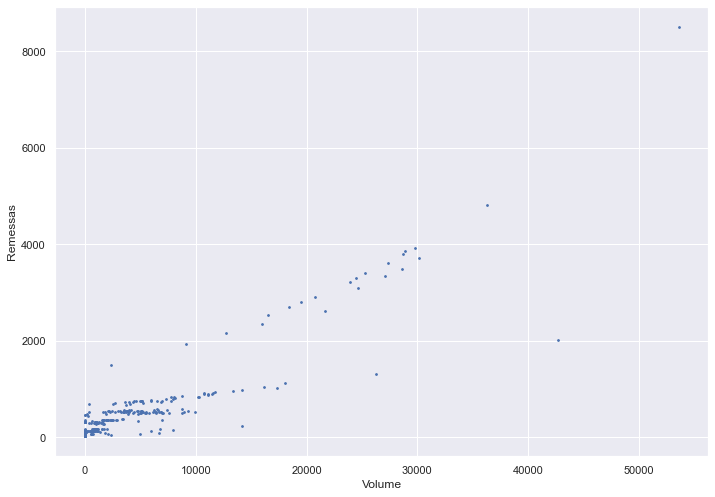

In [111]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoPoisson, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Assimetria: 4.231141450912984
Curtose: 24.435344839379972


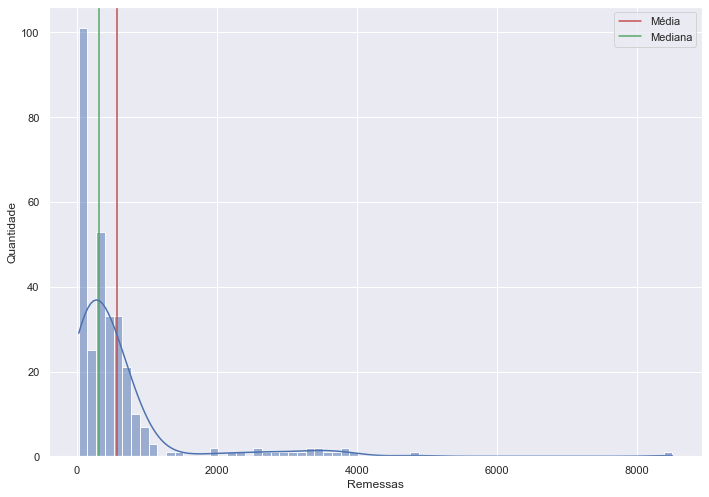

In [112]:
gerarHistograma(resultadoPoisson)

Parece bom... Mas, o quão bom?

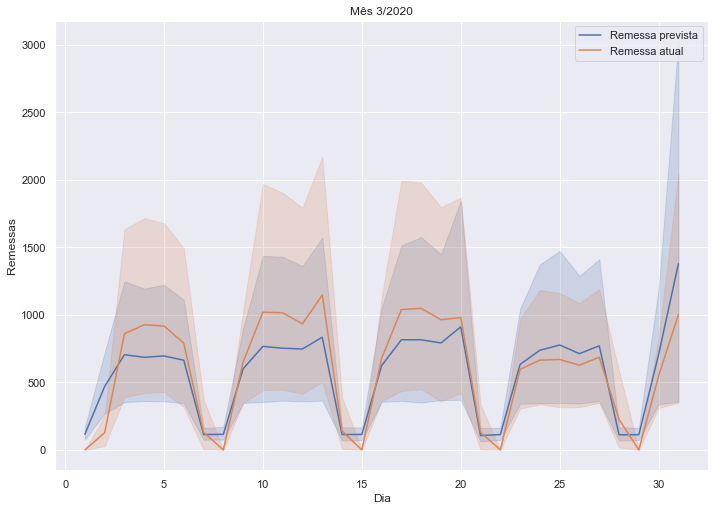

In [113]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultadoPoisson, comecoMes = 0, saveImage = True, nome = 'LR mensal')

<Figure size 842.4x595.44 with 0 Axes>

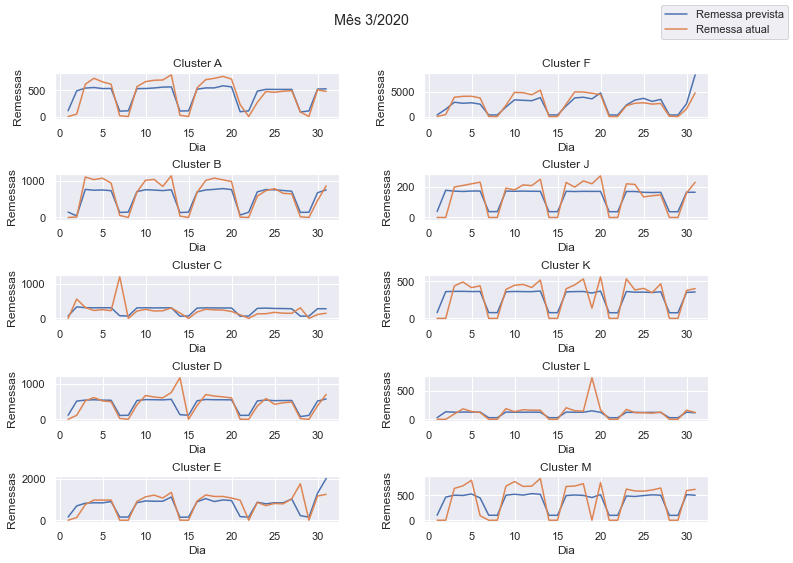

In [114]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultadoPoisson, comecoMes = 0, saveImage = True, nome = 'clustersPoisson')

O gráfico mensal parece se aproximar do valor real, mas será que esse modelo estatístico se saiu melhor que os outros? As métricas podem confirmar ou negar.

In [115]:
gerarMetricaGeral(y_teste, resultadoPoisson)

Mean Squared Error: 160352.36462725562
Root Mean Squared Error: 400.4402135491085
Mean Absolute Error: 200.15394842712965



In [116]:
gerarMetricasClusters(X_teste, y_teste, resultadoPoisson)

No Cluster A
Mean Squared Error: 19890.20317996019
Root Mean Squared Error: 141.03263161396438
Mean Absolute Error: 113.76386856087413

No Cluster B
Mean Squared Error: 36464.77752618965
Root Mean Squared Error: 190.9575280689129
Mean Absolute Error: 160.4982399227724

No Cluster C
Mean Squared Error: 52834.404216257935
Root Mean Squared Error: 229.85735623698872
Mean Absolute Error: 128.08755026958184

No Cluster D
Mean Squared Error: 50280.550530321496
Root Mean Squared Error: 224.2332502781902
Mean Absolute Error: 133.9197966055647

No Cluster E
Mean Squared Error: 143935.95385528146
Root Mean Squared Error: 379.3889216296141
Mean Absolute Error: 229.17407666695956

No Cluster F
Mean Squared Error: 1229132.1652462848
Root Mean Squared Error: 1108.6623314816304
Mean Absolute Error: 869.4694376456348

No Cluster J
Mean Squared Error: 3070.715068463653
Root Mean Squared Error: 55.41403313659504
Mean Absolute Error: 45.8502434531958

No Cluster K
Mean Squared Error: 13639.588250060455
R

Os resultados da distribuição de Poisson não foram muito diferentes obtidos pela Regressão Linear, caindo no mesmo problema: o algoritmo não sabe identificar os zeros e lidar com eles. 

In [117]:
gerarExcel(resultadoPoisson, X_teste, mes = mes, ano = ano, nome = 'Poisson', train = True)

### Distribuição de Poisson com *Zero-Inflated Regressor*

Então, para melhorar o modelo estatístico, o regressor para conjuntos de dados inflados por zeros pode resolver. Como classificador, esse modelo utiliza o *Random Forest* e, para o regressor, a Distribuição de Poisson padrão.

In [118]:
resultadoZIRPoisson = gerarResultadoZIRPoisson(X_treino, X_teste, y_treino)

Text(0, 0.5, 'Remessas')

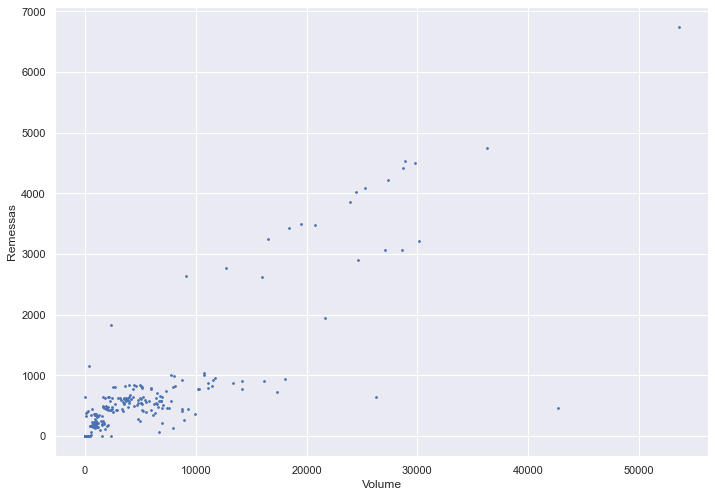

In [119]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoZIRPoisson, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Assimetria: 3.3887116624804756
Curtose: 12.733716498468127


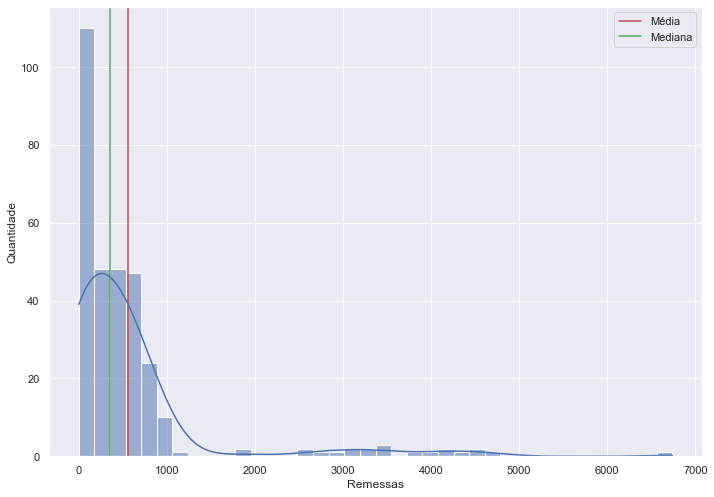

In [120]:
gerarHistograma(resultadoZIRPoisson, saveImage = True, nome = 'hist_ZIR_Poisson')

Os valores parecem um pouco melhor distribuidos... E a previsão?

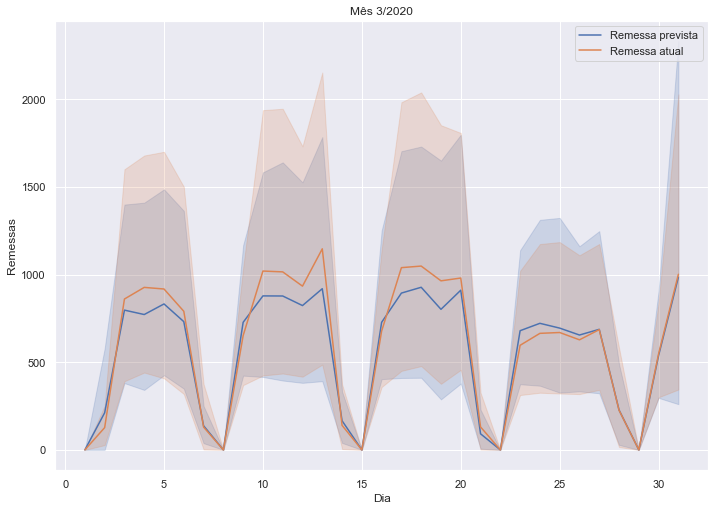

In [121]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultadoZIRPoisson, comecoMes = 0, saveImage = True, nome = 'clustersZIRPoisson')

<Figure size 842.4x595.44 with 0 Axes>

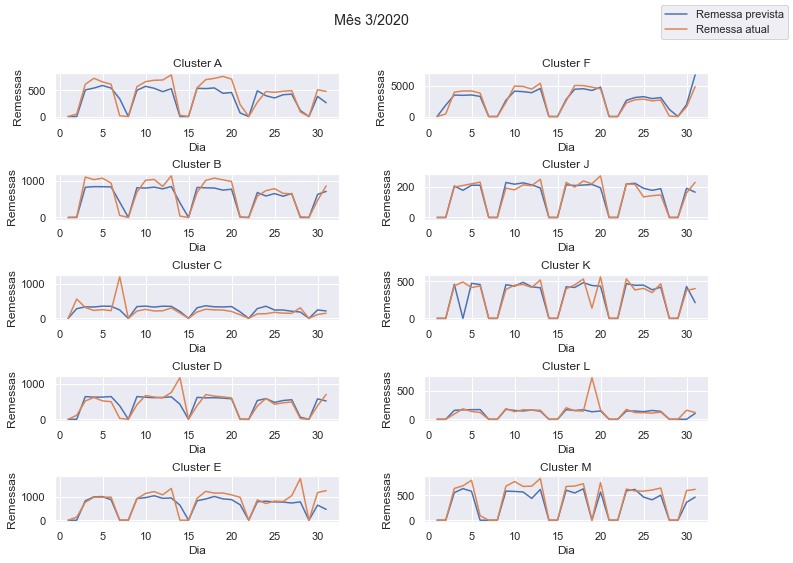

In [122]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultadoZIRPoisson, comecoMes = 0, saveImage = True, nome = 'clustersPoisson')

Uma melhora considerável em relação ao gráfico da Distribuição de Poisson padrão. Agora, as métricas.

In [123]:
gerarMetricaGeral(y_teste, resultadoZIRPoisson, save = True, nome = 'metricas_ZIR_Poisson')

Mean Squared Error: 68016.69194351199
Root Mean Squared Error: 260.80009958493497
Mean Absolute Error: 135.48454318468586



In [124]:
gerarMetricasClusters(X_teste, y_teste, resultadoZIRPoisson, save = True, nome = 'clusters_ZIR_Poisson')

No Cluster A
Mean Squared Error: 22781.87630402639
Root Mean Squared Error: 150.93666322012817
Mean Absolute Error: 116.67804092902433

No Cluster B
Mean Squared Error: 31755.600262792545
Root Mean Squared Error: 178.20101083549594
Mean Absolute Error: 139.10445389444678

No Cluster C
Mean Squared Error: 41760.06306483548
Root Mean Squared Error: 204.35279069500245
Mean Absolute Error: 118.74762575124656

No Cluster D
Mean Squared Error: 32319.013935079307
Root Mean Squared Error: 179.77489795596966
Mean Absolute Error: 104.13911196969289

No Cluster E
Mean Squared Error: 96965.69668635855
Root Mean Squared Error: 311.3931545271324
Mean Absolute Error: 195.51565697710328

No Cluster F
Mean Squared Error: 411827.9536576474
Root Mean Squared Error: 641.7382282969025
Mean Absolute Error: 473.17197791315004

No Cluster J
Mean Squared Error: 857.5370527848878
Root Mean Squared Error: 29.283733586837723
Mean Absolute Error: 19.068237290142612

No Cluster K
Mean Squared Error: 13885.140418414

Valores definitivamente melhores que a distribuição normal. Valores variando por volta dos 18 até 120, com um erro maior nos *clusters* E e F. Apesar do *cluster* L ter um pico entre os dias 15 e 20 que o modelo não previu, ele se manteve estável no resto do mês, fazendo sua média de erro absolto ser um valor baixo. Por isso a importância de avaliar tanto os gráficos quanto as métricas.

In [125]:
gerarExcel(resultadoZIRPoisson, X_teste, mes = mes, ano = ano, nome = 'ZIR_Poisson', train = True)

## Conclusão

Os algoritmos que se saíram melhor nesse case foram ambas as implementações de *Random Forest*. Os modelos previram valores 0 corretamente e chegaram muito próximos do valor real do mês analisado do conjunto de dados. Os modelos que se saíram relativamente bem foram as implementações da Distribuição de Poisson, com destaque à versão inflada por zeros. Já a regressão linear não se saiu bem, possivelmente tendo causa a quantidade de 0 que existe no modelo, atrapalhando na hora da sua predição. 

## Modelos preditivos para o conjunto de dados "Plano de Volume"

Agora, os modelos serão treinados com o dataset "Plano de Volume" e, então, gerar um arquivo em Excel com os resultados.

In [126]:
X_treino, X_teste, y_treino = gerarDados(trainTestSplit = True)

### *Random Forest* convencional

In [127]:
resultadoRF = gerarResultadoRandomForest(X_treino, X_teste, y_treino)

In [128]:
gerarExcel(resultadoRF, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_RandomForest')

### *Random Forest* com Zero-Inflated Regressor

In [129]:
resultado_RF_ZIR = gerarResultadoZIRRandomForest(X_treino, X_teste, y_treino)

In [130]:
gerarExcel(resultado_RF_ZIR, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_ZIR_RandomForest')

### Regressão Linear

In [131]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino)

Features utilizadas: ['Volume']


In [132]:
gerarExcel(resultadoLR, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_Linear_Regression')

### Distribuição de Poisson

In [133]:
resultadoPoisson = gerarResultadoPoisson(X_treino, X_teste, y_treino)

In [134]:
gerarExcel(resultadoPoisson, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_Poisson')

### Distribuição de Poisson com *Zero-Inflated Regressor*

In [135]:
resultado_Poisson_ZIR = gerarResultadoZIRPoisson(X_treino, X_teste, y_treino)

In [136]:
gerarExcel(resultado_Poisson_ZIR, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_Poisson_ZIR')